# Ensemble Transformer and GNN

This notebook builds an ensemble of several variants of the Transformer and GNN model.<br>
A more detailed description can be found in the document:<br>
https://qudata.com/projects/icecube-neutrino/en/ensemble.html

The data for training the ensemble was received in a laptop on kaggle and loaded from google drive

## Libs and some functions

In [ ]:
!pip install qunet==0.0.4    # our DL lib
!pip install torchinfo

import os, gc, sys, time, datetime, math, random, copy, psutil
import numpy as np,  matplotlib.pyplot as plt, pandas as pd
from   pathlib   import Path        
from   tqdm.auto import tqdm
import pyarrow, pyarrow.parquet as pq     # read by chanks
import torch, torch.nn as nn
from   torchinfo import summary

from qunet.models   import MLP
from qunet.data     import Data
from qunet.trainer  import Trainer
from qunet.optim    import CosScheduler, ExpScheduler

#-------------------------------------------------------------------------------

def angles2vector(df):
    """ 
    Add unit vector components from (azimuth,zenith) to the DataFrame df 
    """
    df['nx'] = np.sin(df.zenith) * np.cos(df.azimuth)
    df['ny'] = np.sin(df.zenith) * np.sin(df.azimuth)
    df['nz'] = np.cos(df.zenith) 
    return df

#-------------------------------------------------------------------------------

def vector2angles(n, eps=1e-8):
    """  
    Get spherical angles of vector n: (B,3) 
    """                
    n = n / (np.linalg.norm(n, axis=1, keepdims=True) + eps)    
                                
    azimuth = np.arctan2( n[:,1],  n[:,0])    
    azimuth[azimuth < 0] += 2*np.pi
                                
    zenith = np.arccos( n[:,2].clip(-1,1) )                                
    
    return azimuth, zenith

#-------------------------------------------------------------------------------

def angle_errors(n1, n2, eps=1e-8):
    """ 
    Calculate angles between two vectors:: n1,n2: (B,3) return: (B,) 
    """
    n1 = n1 / (np.linalg.norm(n1, axis=1, keepdims=True) + eps)
    n2 = n2 / (np.linalg.norm(n2, axis=1, keepdims=True) + eps)
    
    cos = (n1*n2).sum(axis=1)                     # angles between vectors
    angle_err = np.arccos( cos.clip(-1,1) )    
        
    r1   =  n1[:,0]*n1[:,0] + n1[:,1]*n1[:,1]    # angles between vectors in (x,y)    
    r2   =  n2[:,0]*n2[:,0] + n2[:,1]*n2[:,1]
    cosX = (n1[:,0]*n2[:,0] + n1[:,1]*n2[:,1]) / (np.sqrt(r1*r2) + eps)    
    azimuth_err = np.arccos( cosX.clip(-1,1) )
                                
    zerros = r1 < eps                            # azimuth angle not defined
    azimuth_err[zerros] = np.random.random((len(n1[zerros]),))*np.pi
    
    zenith1  = np.arccos( n1[:,2].clip(-1,1) )
    zenith2  = np.arccos( n2[:,2].clip(-1,1) )
    zenith_err = zenith2 - zenith1    
        
    return angle_err, azimuth_err, zenith_err

#-------------------------------------------------------------------------------

def info(text, pref="", end="\n"):
    """ 
    Information about the progress of calculations (time and memory) 
    """
    gc.collect()
    ram, t = psutil.virtual_memory().used / 1024**3,  time.time()    
    print(f"{pref}{(t-info.beg)/60:5.1f}m[{t-info.last:+5.1f}s] {ram:6.3f}Gb > {text}",end=end)
    info.last = time.time(); 
info.beg = info.last = time.time()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Aggregated features

In fact, the aggregated features of the event were not included in the ensemble (they did not improve the competition metric)

In [ ]:
batches = 80

USED_AGG = False
if USED_AGG:
    info('beg')
    agg0_df = pd.read_parquet(f"/content/drive/MyDrive/IceCube-Dataset/AGG/agg0_batch_1_{batches}.parquet") 
    display(agg0_df.head(1))
    print(agg0_df.shape)
    #agg = torch.Tensor(agg0_df.iloc[:, 1:].to_numpy()).to(torch.float32)
    info('del')
    agg = torch.Tensor(agg0_df[['lines','doms','core','pulses','qx','qy','qz','Ixx','Iyy','Izz','Ixy','Ixz','Iyz']].to_numpy()).to(torch.float32)
    #agg = torch.Tensor(agg0_df[['lines','doms','core','pulses']].to_numpy()).to(torch.float32)
    del agg0_df; gc.collect()
    info(f'end size:{agg.numel()*4/1024**3:.3f}Gb')
else:
    agg = None


## Current models

For each architecture, 3 models were selected, the results of which on the first 80 batches of training data are loaded from a google drive.

First, we calculate the error of each model and the ensemble based on the simple mean.

In [ ]:
info("start models")

# Target values of the direction vector component for the first 80 batches:
true_df = pd.read_parquet(f"/content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/true_batch_1_{batches}.parquet") 
display(true_df.head(2))

models = [        
    # GNN:
    f"/content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_gnn_id_26_val_0_9926_exp_classific_16n_e1633_batch_1_{batches}.csv",  # gnn1    
    f"/content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_gnn_id_28_val_0_9919_exp_classific_24n_e726_batch_1_{batches}.csv",   # gnn2    
    f"/content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_gnn_id_27_val_0_9961_exp_readout_emb_e196_batch_1_{batches}.csv",     # gnn3   


    # ATT:    
    f"/content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_att_all_0.9984_L12_batch_1_{batches}.csv",     # att1    ~AGG_DOMS 
    f"/content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_att_rnn_1.0015_L10_batch_1_{batches}.csv",     # att2     AGG_DOMS    
    f"/content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_att04_1.0003_D00_batch_1_{batches}.csv",       # att4     AGG_DOMS       
]

models_df = true_df[['event_id','nx','ny','nz']].copy()
models_df.rename(columns={"nx": "nx_true", "ny": "ny_true", "nz": "nz_true"}, inplace=True)

for i, m in tqdm(enumerate(models), total=len(models)):
    df = pd.read_csv(m)    
    print(df.shape, m)
    df = angles2vector(df)[['event_id', 'nx','ny','nz']].copy()    
    df.rename(columns={"nx": f"nx_{i+1:0d}", "ny": f"ny_{i+1:0d}", "nz": f"nz_{i+1:0d}"}, inplace=True)
    models_df = models_df.merge(df, left_on='event_id', right_on='event_id', how='left')
del df

n_true = models_df[['nx_true','ny_true','nz_true']].to_numpy()

print(f"total samples: {models_df.shape};  number of nan: {models_df.isna().sum().sum()}")    

#--------------------------------------------------------------------------------------------------
B, T, E = len(models_df), len(models), 3
n_val = int(5*B/batches)

# calc ensemble with equal weights
n_true = models_df[['nx_true','ny_true','nz_true']].to_numpy()
n_pred = np.zeros_like(n_true)
for i in range(len(models)):
    n = models_df.iloc[:, 4+i*3 : 4+(i+1)*3].to_numpy()        
    ang_err, az_err, ze_err = angle_errors(n[:n_val], n_true[:n_val])    
    errs = ang_err.reshape(-1,1) if i==0 else np.column_stack([errs, ang_err.reshape(-1,1)])                             # norm: {np.linalg.norm(n, axis=1).mean():.2f} 
    print(f"{i:3d}  > ang_err: {ang_err.mean():.4f}; az_err: {az_err.mean():.3f} ze_err: {np.abs(ze_err).mean():.3f}  | {models[i][61:]}") 
    n_pred += n

print("---------------------------------------------------------------")
ang_err, az_err, ze_err = angle_errors(n_pred[:n_val], n_true[:n_val])
print(f"mean > ang_err: {ang_err.mean():.4f}; az_err: {az_err.mean():.3f} ze_err: {np.abs(ze_err).mean():.3f}")

corr = pd.DataFrame(errs).corr()
display(corr)
#plt.matshow(corr, cmap="bwr"); plt.show()


  0.0m[ +0.1s]  1.075Gb > start models


,event_id,batch_id,azimuth,zenith,nx,ny,nz
0,24,1,5.029555,2.087497,0.271161,-0.826088,-0.494015
1,41,1,0.417742,1.549686,0.913804,0.405607,0.021108


  0%|          | 0/6 [00:00<?, ?it/s]

(16000000, 3) /content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_gnn_id_26_val_0_9926_exp_classific_16n_e1633_batch_1_80.csv
(16000000, 3) /content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_gnn_id_28_val_0_9919_exp_classific_24n_e726_batch_1_80.csv
(16000000, 3) /content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_gnn_id_27_val_0_9961_exp_readout_emb_e196_batch_1_80.csv
(16000000, 3) /content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_att_all_0.9984_L12_batch_1_80.csv
(16000000, 3) /content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_att_rnn_1.0015_L10_batch_1_80.csv
(16000000, 3) /content/drive/MyDrive/IceCube/IceCube-Dataset/AGG/Models/submission_att04_1.0003_D00_batch_1_80.csv
total samples: (16000000, 22);  number of nan: 0
  0  > ang_err: 0.9947; az_err: 1.036 ze_err: 0.607  | mission_gnn_id_26_val_0_9926_exp_classific_16n_e1633_batch_1_80.csv
  1  > ang_err: 0.9931; az_err: 1.034 ze_err: 0.596  |

,0,1,2,3,4,5
0,1.000000,0.958964,0.949161,0.807849,0.782554,0.817278
1,0.958964,1.000000,0.939519,0.820717,0.795359,0.829694
2,0.949161,0.939519,1.000000,0.808230,0.783209,0.817874
3,0.807849,0.820717,0.808230,1.000000,0.940014,0.983527
4,0.782554,0.795359,0.783209,0.940014,1.000000,0.913282
5,0.817278,0.829694,0.817874,0.983527,0.913282,1.000000


## Dataset

We form the training and validation dataset.
Validation is carried out on the first 5 batches.

In [ ]:
class CFG:
    loss   = 'cos'
    ka_reg = 0    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
info('beg')
B, T, E = len(models_df), len(models), 3

print(f"B:{B}, T:{T}, E:{E}")
X = torch.Tensor(models_df.iloc[:, 4:].to_numpy()).view(B,T,E)   # (B,T,E)
Y = torch.Tensor(models_df.iloc[:,1:4].to_numpy())               # (B,E)

#del models_df  # if there is not enough memory!!!!

if agg is None:
    agg = Y

info('data')
n_val = int(5*B/batches)                                         # validate on the first 5 batches
data_val = Data( [X[:n_val], agg[:n_val],  Y[:n_val]], batch_size=4*1024,  device=CFG.device, shuffle=False, whole_batch=False)
data_trn = Data( [X[n_val:], agg[n_val:],  Y[n_val:]], batch_size=8*1024,  device=CFG.device, shuffle=True,  whole_batch=True,  n_packs=4)
del agg; del X; del Y;
gc.collect()
info('end')

  2.9m[+172.3s]  5.214Gb > beg
B:16000000, T:6, E:3
  2.9m[ +2.1s]  6.219Gb > data
data:[torch.Size([1000000, 6, 3]), torch.Size([1000000, 3]), torch.Size([1000000, 3])]
data:[torch.Size([15000000, 6, 3]), torch.Size([15000000, 3]), torch.Size([15000000, 3])]
  2.9m[ +0.2s]  6.237Gb > end


## Models

In [ ]:
def metrics(x, Y, eps=1e-8):
    """ 
    loss of the model and angle error (score of competition)
    """
    kappa = torch.norm(x, dim=1, keepdim=True).clip(eps)
    y = x / kappa 
    cos  = (y*Y).sum(dim=1) 
    if   CFG.loss == 'cos':
        loss = 1 - cos.mean() + CFG.ka_reg * (kappa**2).mean()
    elif   CFG.loss == 'mse':
        loss = (x-Y).pow(2).sum(-1).mean()
    elif CFG.loss == 'prod':
        loss = -((x*Y).sum(dim=1)).mean() + CFG.ka_reg * kappa.mean()
    elif CFG.loss == 'vMF':
        logC = -kappa + torch.log( ( kappa+eps )/( 1-torch.exp(-2*kappa)+2*eps ) )
        loss = -( (x*Y).sum(dim=1) + logC ).mean() 
    elif CFG.loss == 'k2':             
        loss = -((x*Y).sum(dim=1)).mean() + 0.5 * (kappa**2).mean()
    elif CFG.loss == 'k2ze':
        loss = -((x*Y).sum(dim=1)).mean() + 0.5 * (kappa**2).mean() + torch.square(y[:,2]-Y[:,2]).mean()

    err  = torch.abs( torch.arccos(  torch.clip(cos.detach() ,-1,1) ) )
    return loss,  y.detach(),  torch.cat([err.view(-1,1), kappa.detach().view(-1,1)], dim=1 )

#-------------------------------------------------------------------------------    

class MLP_Model(nn.Module):
    """
    All model outputs, possibly supplemented by aggregated event features, are fed to the MLP input
    """

    def __init__(self, cfg: dict):        
        super().__init__() 
        self.cfg = {
            'name':      'mlp',
            'n_models':  2,
            'is_agg':    False,        
            'AF':        31,                        # number of aggregated features
            'AC':        2,                         # number of compressed aggregated features
            'hidden':    256,
            'drop':      0.01,
        }   
        if type(cfg) is dict:                       # add, change properties
            self.cfg.update(copy.deepcopy(cfg))
        cfg = self.cfg
        
        self.mlpf = MLP( dict(input=cfg['AF'], scale=4, output=cfg['AC'], drop=cfg['drop']) )  \
                    if  cfg['is_agg'] else None

        F = cfg['n_models']*3
        if cfg['is_agg']:  F += cfg['AC']
        self.mlp = MLP( dict(input=F, hidden=cfg['hidden'], output=3, drop=cfg['drop']) )        

    def forward(self, batch, eps=1e-8):      
        x,  agg, Y = batch
        B,T,E = x.shape
        x = x.view(B, T*E)     

        if self.mlpf is not None:
            agg = self.mlpf(agg)
            agg = nn.Tanh()(agg)
            x = torch.cat([x, agg], dim=-1)
    
        x = self.mlp(x)

        return metrics(x,Y)

## Create Model

In [ ]:
model = MLP_Model ( dict(n_models=len(models), hidden=1024*2, is_agg=False, AF=13, AC=3, drop=0.2 ) )    

model.to(CFG.device)
display(summary(model, col_width = 20))
print(model.cfg)

trainer = Trainer(model, data_trn, data_val)
trainer.scheduler = CosScheduler()

trainer.set_optimizer( torch.optim.Adam(model.parameters(), lr=1e-3) ) # weight_decay=1e-4
trainer.copy_best_model = True

Layer (type:depth-idx)                   Param #
MLP_Model                                --
├─MLP: 1-1                               --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  38,912
│    │    └─GELU: 3-2                    --
│    │    └─Dropout: 3-3                 --
│    │    └─Linear: 3-4                  6,147
Total params: 45,059
Trainable params: 45,059
Non-trainable params: 0

{'name': 'mlp', 'n_models': 6, 'is_agg': False, 'AF': 13, 'AC': 3, 'hidden': 2048, 'drop': 0.2}


## Train

batches: 80
 20v[100%]  score=0.9817 (74.5816) loss=0.5788   samples=1000000 steps=1  time=3.11e+02ms/step  0.31s/1e6  
time = (trn:1.55, val:0.03, tot:1.57)m  lr:6.9e-03


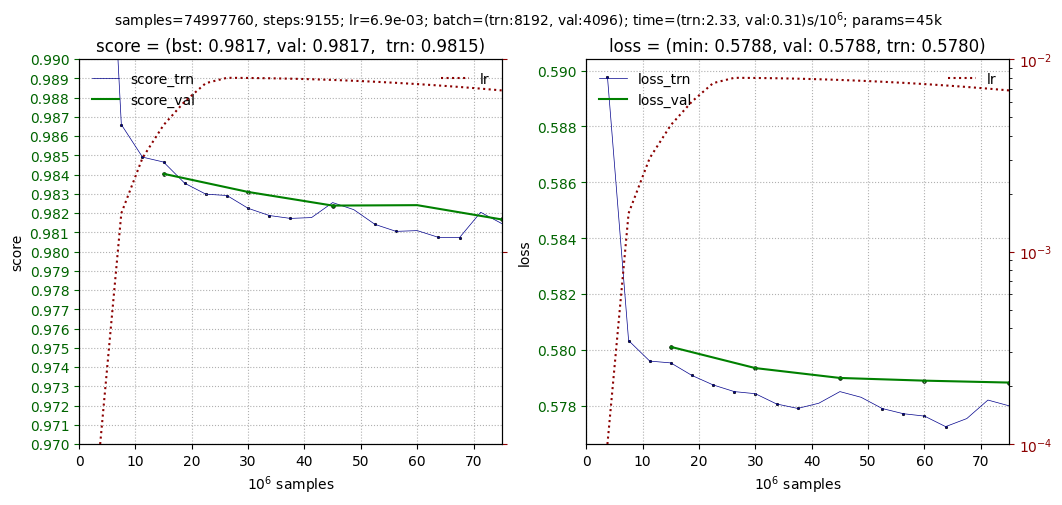

 40v[100%]  score=0.9807 (182.5444) loss=0.5786   samples=1000000 steps=1  time=3.02e+02ms/step  0.30s/1e6  
time = (trn:2.91, val:0.10, tot:3.01)m  lr:3.2e-03


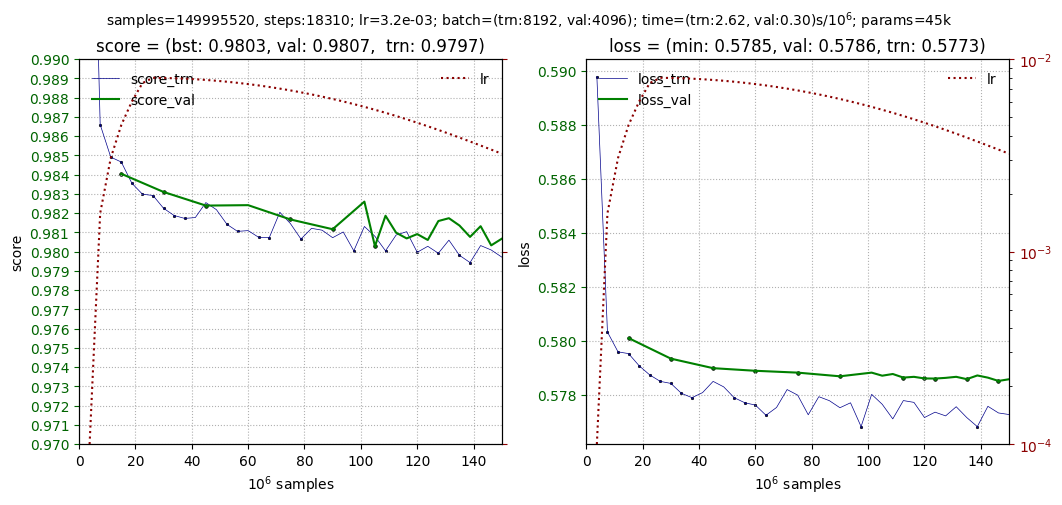

 54v[100%]  score=0.9801 (191.1986) loss=0.5785   samples=1000000 steps=1  time=2.9e+02ms/step  0.29s/1e6  

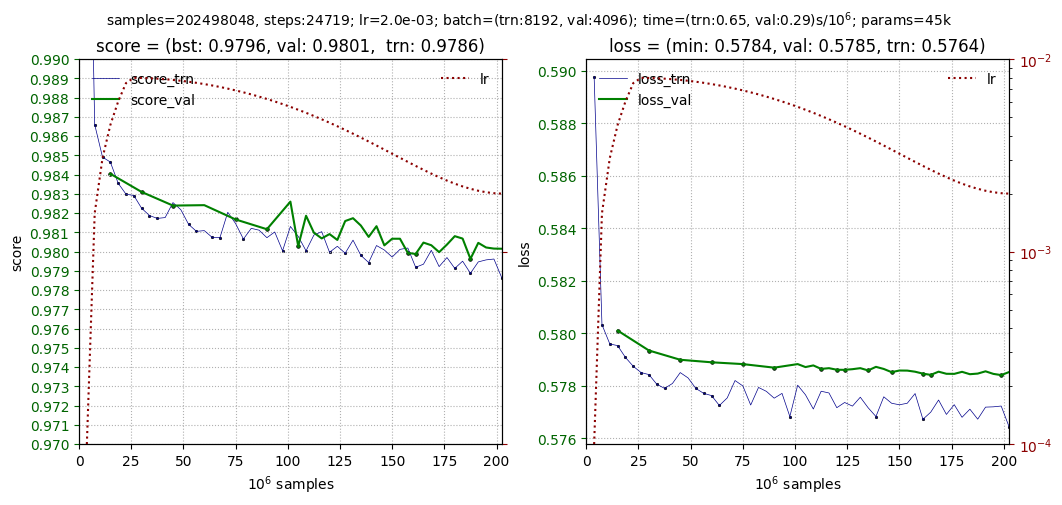


CPU times: user 3min 46s, sys: 11.2 s, total: 3min 57s
Wall time: 4min 2s


In [ ]:
%%time
print("batches:", batches)
CFG.loss = 'cos'
trainer.scheduler.set(lr1=1e-4, lr_hot=8e-3, lr2=2e-3, samples=200e6, warmup=20e6)
trainer.cfg['plot_score'].update(dict(y_min=0.970, y_max=0.990, ticks=21))
trainer.run(epochs=1000, 
            stop_after_samples = 200e6, 
            samples_beg = 100e6,    # потом включается period_val=1
            period_val_beg = 4,     # период валидации на первых samples_beg примерах            
            period_plot=20)
print()


 20v[100%]  score=0.9799 (194.1685) loss=0.5784   samples=1000000 steps=1  time=2.91e+02ms/step  0.29s/1e6  
time = (trn:5.19, val:0.26, tot:5.45)m  lr:1.2e-03


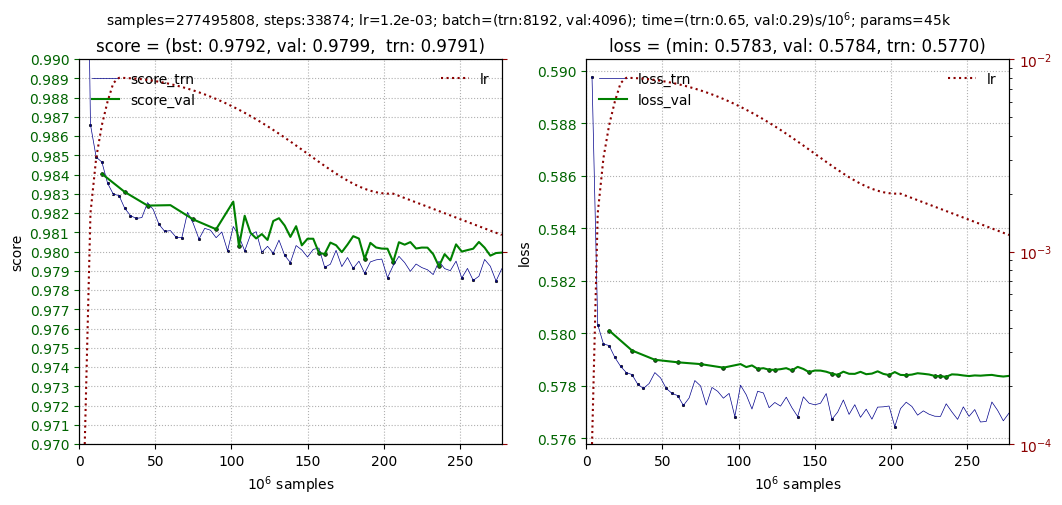

 40v[100%]  score=0.9799 (189.7508) loss=0.5783   samples=1000000 steps=1  time=3.04e+02ms/step  0.30s/1e6  
time = (trn:6.58, val:0.37, tot:6.95)m  lr:7.3e-04


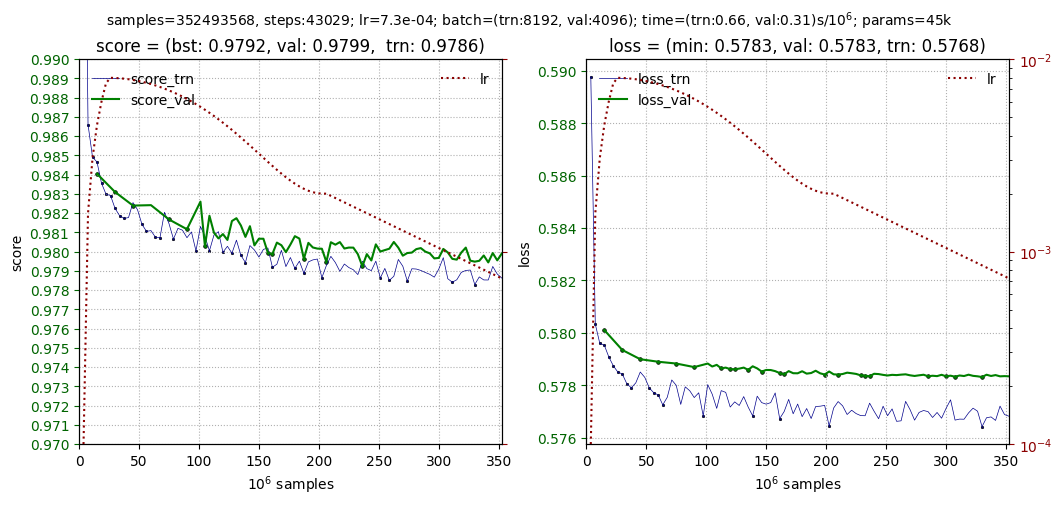

 54v[100%]  score=0.9798 (187.2751) loss=0.5783   samples=1000000 steps=1  time=3.18e+02ms/step  0.32s/1e6  

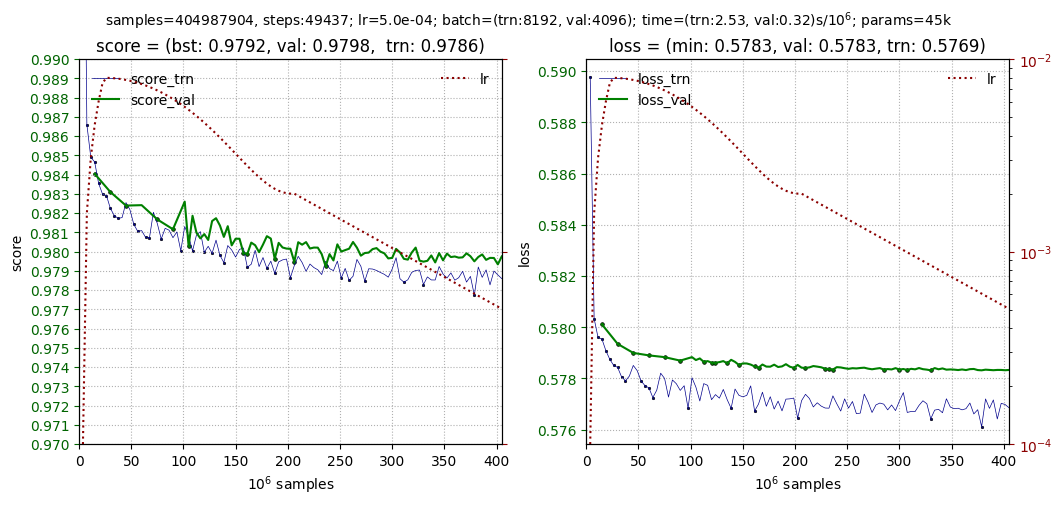

CPU times: user 3min 52s, sys: 11.7 s, total: 4min 4s
Wall time: 4min 8s


In [ ]:
%%time
trainer.scheduler = ExpScheduler( trainer.optim)
trainer.set_optimizer( torch.optim.Adam(model.parameters(), lr=1e-3) )
trainer.scheduler.set(lr1=2e-3,  lr2=5e-4, samples=200e6)
trainer.run(epochs=1000, 
            stop_after_samples = 200e6, 
            period_plot=20)

## Saving, checking

In [ ]:
if False:
    folder = "/content/drive/MyDrive/IceCube-Ensemble/"
    fname  = f"ens_err_{trainer.best_score_val:.4f}_mlp2048_aggF_gnn_1_2_3_att_1_2_4.pt"
    trainer.labels = []
    trainer.sample = trainer.samples
    trainer.save(folder+fname, trainer.model_best_score, info="MLP")

In [ ]:
if False:
    losses, scores, counts, (_,_,tm_trn) = trainer.fit(0,trainer.model_best_score, data_val, train=False)
    loss_val, score_val = trainer.mean(losses, scores, counts)
    print(score_val)

## Ensemble use

In [ ]:
def load_ensemble_model(fname):
    state = torch.load(fname)  
    print(state['config'])        
    model = MLP_Model(state['config'])    
    model.load_state_dict(state['model'])     
    return model, state['data']

if True:
    # Загружаем:
    fname = '/content/drive/MyDrive/IceCube/IceCube-Ensemble/ens_err_0.9792_mlp2048_aggF_gnn_1_2_3_att_1_2_4.pt'
    model, data = load_ensemble_model(fname)
    model.to(CFG.device)

    print(model)

    trainer = Trainer(model, None, None)
    trainer.plotter.plot(trainer.cfg, model, data, w=12, h=4)

    # Создаём датасет:
    B, T, E = len(models_df), len(models), 3
    X = torch.Tensor(models_df.iloc[:, 4:].to_numpy()).view(B,T,E)   # (B,T,E)
    Y = torch.Tensor(models_df.iloc[:,1:4].to_numpy())               # (B,E)
    data_tst = Data( (X, Y,  Y), batch_size=1024,  device=CFG.device, shuffle=False, whole_batch=False)

    output, losses, score = trainer.predict(model, data_tst, verbose=True)
    print()
    print(f"output: {output.shape}  err:{score.mean(0)[0]:.4f}   kappa:{score.mean(0)[1]:.4f}")